In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import matplotlib.font_manager as fm
import time
import os
import openpyxl

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore')

In [2]:
# def load_data(FILE_NAME):
#     if not os.path.exists(FILE_NAME):
#         print(f"⚠️ 파일 '{FILE_NAME}'이(가) 존재하지 않습니다. 동일한 경로에 파일을 추가한 뒤 다시 실행하세요.")
#         input("⛔ Enter 키를 누르면 프로그램이 종료됩니다.")
#         exit()  # 프로그램 종료
        
#     try:
#         df = pd.read_csv(FILE_NAME)
#         return df
    
#     except Exception as e:
#         print(f"⚠️ 데이터를 불러오는 중 오류가 발생했습니다: {e}")
#         print(f"⚠️ 프로그램을 종료 후 다시 실행하세요.")
#         input("⛔ Enter 키를 누르면 프로그램이 종료됩니다.")
#         exit()  # 프로그램 종료

In [3]:
def pre_process(df):
    df['입고일'] = pd.to_datetime(df['입고일'])
    df = df[~((df['매입량'].notnull()) & (df['입고량(매입량)'] != df['매입량']))]
    df.drop(columns = ['매입량'], inplace = True)
    df = df[(df['규격'] == '중고') | (df['규격'] == '신품')]
    df = df[df['조달구분'] != '사내가공']
    df = df[df['수불방법'] != '예외']
    df = df[df['수불유형'] == '구매입고']
    df = df[df['발주형태'] == '매입']

    df_new = df.copy()
    df_new['총액'] = df_new['입고량(매입량)'] * df_new['입고단가(매입가)']
    df_new['차액'] = df_new['합계금액(부대비포함)'] - df_new['총액']
    df_new = df_new[~((df_new['차액']>=1000) | (df_new['차액'] <= -1000))]
    
    return df_new

In [4]:
directory  = os.getcwd()
print('🌍 매입단가 통계 산출 프로그램을 시작합니다.')
print(f'현재 경로를 표시합니다: {directory}')

FILE_NAME = '매입내역.xlsx'
df = pd.read_excel(f'{directory}/{FILE_NAME}')
# df = load_data(FILE_NAME)
df_new = pre_process(df)

🌍 매입단가 통계 산출 프로그램을 시작합니다.
현재 경로를 표시합니다: YOUR PATH

In [5]:
def find_keyword(keyword, items):
    sim = [i for i in items.unique() if keyword in i.lower()]

    if sim:
        print("✅ 선택 가능한 품목명:")
        print("번호   품목명")
        for idx, item in enumerate(sim):
            print_idx = idx+1
            print(f"{print_idx}     {item}")
        return sim
    else:
        print("\n⚠️ 해당 키워드와 일치하는 품목명이 없습니다.")
        return []

def get_id():
    print('품목명 키워드 예시: 복합기, 모니터, i7 ...')
    print(' ')
    keyword = input('>>>>> 품목의 키워드를 입력하세요: ').strip().lower()
    print(f"🔍 입력한 키워드 : {keyword}")
    print(' ')
    time.sleep(1)
    sim = find_keyword(keyword, df_new['품목명'])

    while True:
        print("➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖")
        print(' ')
        print('1: 현재 선택 가능한 품목명에서 선택')
        print('2: 현재 선택 가능한 품목명에서 추가 키워드 검색')
        print("3: 키워드 재입력")
        print("*: 프로그램 종료")
        menu_choice = input(">>>>> 메뉴를 선택하세요 (1, 2, 3, *): ").strip()
        print(' ')

        if menu_choice == '1':
            if not sim:
                print("⚠️ 선택 가능한 품목명이 없습니다. 처음으로 돌아갑니다.")
                continue
            print_id = input(">>>>> 품목의 번호를 입력하세요: ").strip()
            id = int(print_id)-1

            if print_id.isdigit() and int(id) < len(sim) and int(id) >= 0:
                print(f"✅ 선택한 품목명: {sim[int(id)]} ✅")
                id_name =  sim[int(id)]
                return id_name, df_new[df_new['품목명']==sim[int(id)]]
                break
            else:
                print("⚠️ 올바른 번호를 입력하세요.")

        elif menu_choice == '2':
            if not sim:
                print("⚠️ 선택 가능한 품목명이 없습니다. 처음으로 돌아갑니다.")
                continue
            add_keyword = input(">>>>> 추가 키워드를 입력하세요: ").strip().lower()
            print(f"🔍 입력한 키워드 : {add_keyword}")
            print(' ')
            filtered_sim = [item for item in sim if add_keyword in item.lower()]

            if filtered_sim:
                print("✅ 추가 검색 후 선택 가능한 품목명:")
                print("번호   품목명")
                for idx, item in enumerate(filtered_sim):
                    print_idx = idx+1
                    print(f"{print_idx}    {item}")
                sim = filtered_sim
            else:
                print("⚠️ 추가 키워드와 일치하는 품목명이 없습니다. 기존 목록을 유지합니다.")

            continue # 메뉴 선택으로 돌아가기

        elif menu_choice == '3':
            keyword = input('>>>>> 품목의 키워드를 입력하세요: ').strip().lower()
            sim = find_keyword(keyword, df_new['품목명'])

        elif menu_choice == '*':
            confirm_exit = input("정말 종료하시겠습니까? (y/n): ").strip().lower()
            if confirm_exit == 'y':
                print("⛔ 프로그램을 종료합니다.")
                input("🔔 Enter 키를 누르면 프로그램이 종료됩니다.")
                break
            else:
                print("💡 프로그램을 계속 실행합니다.")

        else:
            print("⚠️ 올바른 메뉴를 선택하세요.")

In [23]:
def select_timedata(select_time, code_df):
    if len(select_time) == 4: 
        try:
            select_year = int(select_time)
            select_df = code_df[code_df['입고일'].dt.year == select_year]
        except ValueError:
            print("⚠️ 잘못된 연도 형식입니다. 다시 입력하세요.")
            return None
        
    elif len(select_time) == 6:  # 연도와 월 필터링
        try:
            select_year = int(select_time[:4])
            select_month = int(select_time[4:])
            select_df = code_df[
                (code_df['입고일'].dt.year == select_year) & 
                (code_df['입고일'].dt.month == select_month)]
        except ValueError:
            print("⚠️ 잘못된 연도/월 형식입니다. 다시 입력하세요.")
            return None
    
    elif len(select_time) == 13: # YYYYMM-YYYYMM 형식
        try: 
            time1, time2 = select_time.split('-')
            start_year = int(time1[:4])
            start_month = int(time1[4:])
            end_year = int(time2[:4])
            end_month = int(time2[4:])

            start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
            end_date = pd.Timestamp(year=end_year, month=end_month, day=1).replace(day=1) + pd.offsets.MonthEnd(0)
            select_df = code_df[(code_df['입고일'] >= start_date) & (code_df['입고일'] <= end_date)]
        except ValueError:
            print("⚠️ 잘못된 범위 형식입니다. 다시 입력하세요.")
            return None
        
    else:
        print("⚠️ 잘못된 날짜 형식입니다. 다시 입력하세요.")
        return None
    
    return select_df

def select_analysis(select_df):
    plt.rcParams['font.family'] ='Malgun Gothic'
    plt.figure(figsize=(12, 6))

    ax = sns.countplot(data=select_df, x='입고단가(매입가)', palette='viridis')

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',            # 값 표시
                    (p.get_x() + p.get_width() / 2,      # x 좌표
                    p.get_height()),                    # y 좌표
                    ha='center', va='bottom', fontsize=10)

    # 그래프 레이블 설정
    plt.xlabel('입고단가(매입가)', fontsize=12)
    plt.ylabel('데이터 개수', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    count_df = select_df['입고단가(매입가)'].value_counts().reset_index()
    count_df.columns = ['입고단가(매입가)', '데이터 개수']
    return count_df

def save_to_excel(df, filename):
    if os.path.exists(filename):
        print(f"⚠️ 기존 파일 '{filename}'이(가) 존재합니다. 덮어씁니다.")
        os.remove(filename)  # 기존 파일 삭제
    df.to_excel(f'{directory}/통계분석_데이터/{filename}', index=False)  # 새로운 파일 저장
    print(f"📁 분석결과가 '{filename}'파일에 저장되었습니다.")


In [24]:
def root_analysis(id_name, code_df):

    print(f"🔄 {id_name}의 분석을 진행합니다.")
    print(f"📊 {id_name}의 전체 데이터 개수: {len(code_df)}")
    print(' ')
    input("🔔 계속 진행하려면 Enter 키를 누르세요.")
    print("📉 입고일 기준 날짜별 평균 매입단가:")
    grouped_data  = code_df.groupby('입고일')['입고단가(매입가)'].mean().reset_index()

    plt.rcParams['font.family'] ='Malgun Gothic'
    plt.figure(figsize=(15, 6))
    plt.plot(grouped_data['입고일'], grouped_data['입고단가(매입가)'], marker='o', linestyle='-', label='Average Price', markersize=3)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{id_name} 날짜별 평균 매입단가', fontsize=14)
    plt.xlabel('입고일', fontsize=12)
    plt.ylabel('매입단가', fontsize=12)
    plt.xticks(rotation=45)  # 날짜 레이블 회전
    plt.grid(True)
    plt.legend()

    # 그래프 표시
    plt.tight_layout()
    plt.show()

    print("➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖")

    while True:
        print(' ')
        print("1: 전체 매입단가 분석")
        print("2: 날짜 선택으로 매입단가 분석")
        print("3: 새로운 키워드 입력")
        print("*: 프로그램 종료")
        print(' ')

        menu_choice2 = input(">>>>> 메뉴를 선택하세요 (1, 2, 3, *): ").strip()

        if menu_choice2 == '1':
            select_df = code_df
            count_df = select_analysis(select_df)

            filename = f'{id_name}의 전체 매입단가 분석.xlsx'
            save_to_excel(count_df, filename)
            
        elif menu_choice2 == '2':
            print("날짜 입력 예시: 2023년도 데이터 분석➡️2023")
            print("날짜 입력 예시: 2023년도 3월 데이터 분석➡️202303")
            print("날짜 입력 예시: 2022/03 ~ 2022/06 데이터 분석➡️202203-202206")
            time.sleep(1)
            select_time = input(">>>>> 날짜를 입력하세요: ").strip()
            select_df = select_timedata(select_time, code_df)
            if select_df is not None and not select_df.empty:
                count_df = select_analysis(select_df)
                filename = f'{id_name}의 {select_time} 매입단가 분석.xlsx'
                save_to_excel(count_df, filename)
            else:
                print("⚠️ 해당 조건에 맞는 데이터가 없습니다. 다시 시도하세요.")

        elif menu_choice2 == '3':
            print("🔔 품목을 재선택합니다.")
            print(' ')
            return "restart"  # 새로운 품목과 데이터 반환


        elif menu_choice2 == '*':
            confirm_exit = input("정말 종료하시겠습니까? (y/n): ").strip().lower()

            if confirm_exit == 'y':
                print("⛔ 프로그램을 종료합니다.")
                input("🔔 Enter 키를 누르면 프로그램이 종료됩니다.")
                return "exit"
            else:
                print("💡 프로그램을 계속 실행합니다.")


        else:
            print("⚠️ 올바른 메뉴를 선택하세요.")

품목명 키워드 예시: 복합기, 모니터, i7 ...
 
🔍 입력한 키워드 : ssd
 
✅ 선택 가능한 품목명:
번호   품목명
1     120G SSD
2     250G SSD
3     500G SSD
4     64G SSD
5     120G SSD 신품
6     120G SSD 삼성중고
7     250G SSD 삼성중고
8     80G SSD
9     500G SSD 신품(랜덤)
10     500G SSD 삼성중고
11     1TB SSD 삼성중고
12     2TB SSD 삼성중고
13     애플전용 SSD 250G
14     250G SSD 신품
15     32G SSD
16     1TB SSD
17     120G SSD 신품(랜덤)
18     애플전용 SSD 120G
19     2TB SSD
20     1TB SSD 신품
21     4TB SSD
22     500G SSD 신품
23     250G SSD 신품(랜덤)
24     삼성 PRO 512G SSD
25     (렌탈)ASUS TUF Gaming F17 FX707VV4-LL017 (SSD 512GB)
26     (렌탈)삼성전자 데스크탑5 DM500TFZ-i5GR46T (32GB  SSD 1TB)/i5-13400/RTX4060TI
27     (렌탈)ASUS TUF Gaming A16 FA617NS-N4096 (SSD 512GB)
28     (렌탈)i5-12400F / D4 16G / SSD 240G / RTX3060 / H610 / 600W / 크라프트케이스
29     (렌탈)ASUS TUF Gaming A15 FA507NU-R7735D (SSD 512GB)
30     (렌탈)레노버 게이밍 3 15ARH7 R7 4050 (SSD 512GB)
31     (렌탈)레노버 게이밍 3i 15IHU i7 3050Ti PRO W11 (SSD 256GB)
➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖
 
1: 현재 선택

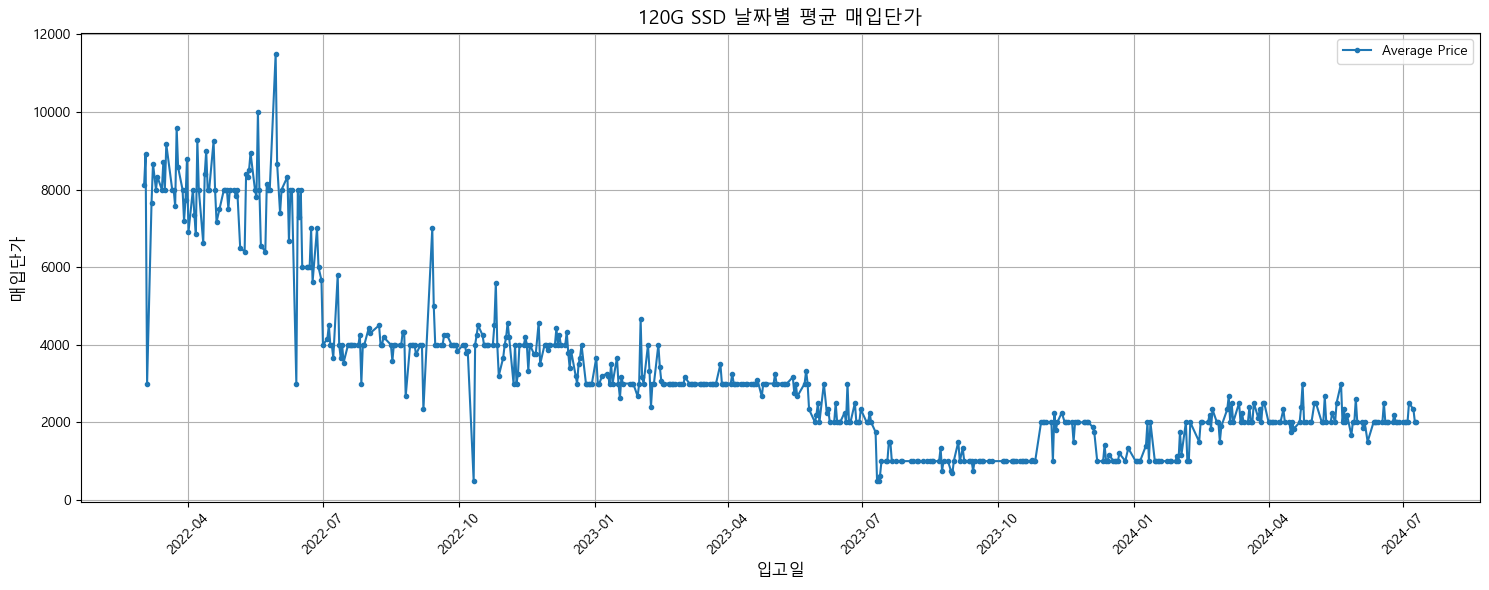

➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖
 
1: 전체 매입단가 분석
2: 날짜 선택으로 매입단가 분석
3: 새로운 키워드 입력
*: 프로그램 종료
 
날짜 입력 예시: 2023년도 데이터 분석➡️2023
날짜 입력 예시: 2023년도 3월 데이터 분석➡️202303
날짜 입력 예시: 2022/03 ~ 2022/06 데이터 분석➡️202203-202206


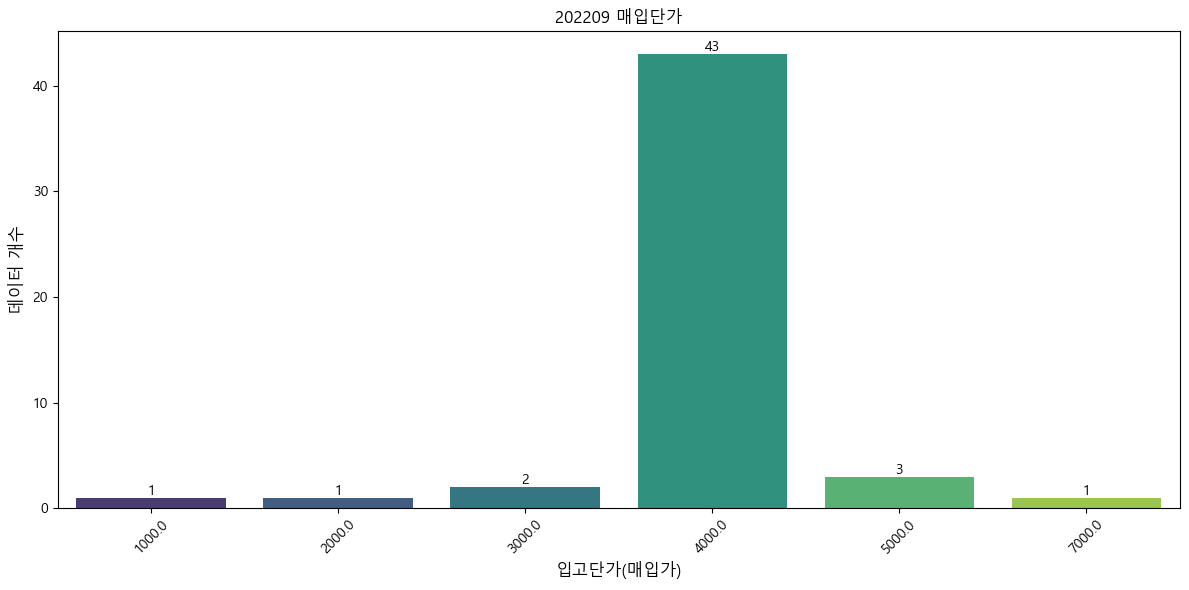

📁 분석결과가 '120G SSD의 202209 매입단가 분석.xlsx'파일에 저장되었습니다.
 
1: 전체 매입단가 분석
2: 날짜 선택으로 매입단가 분석
3: 새로운 키워드 입력
*: 프로그램 종료
 
날짜 입력 예시: 2023년도 데이터 분석➡️2023
날짜 입력 예시: 2023년도 3월 데이터 분석➡️202303
날짜 입력 예시: 2022/03 ~ 2022/06 데이터 분석➡️202203-202206


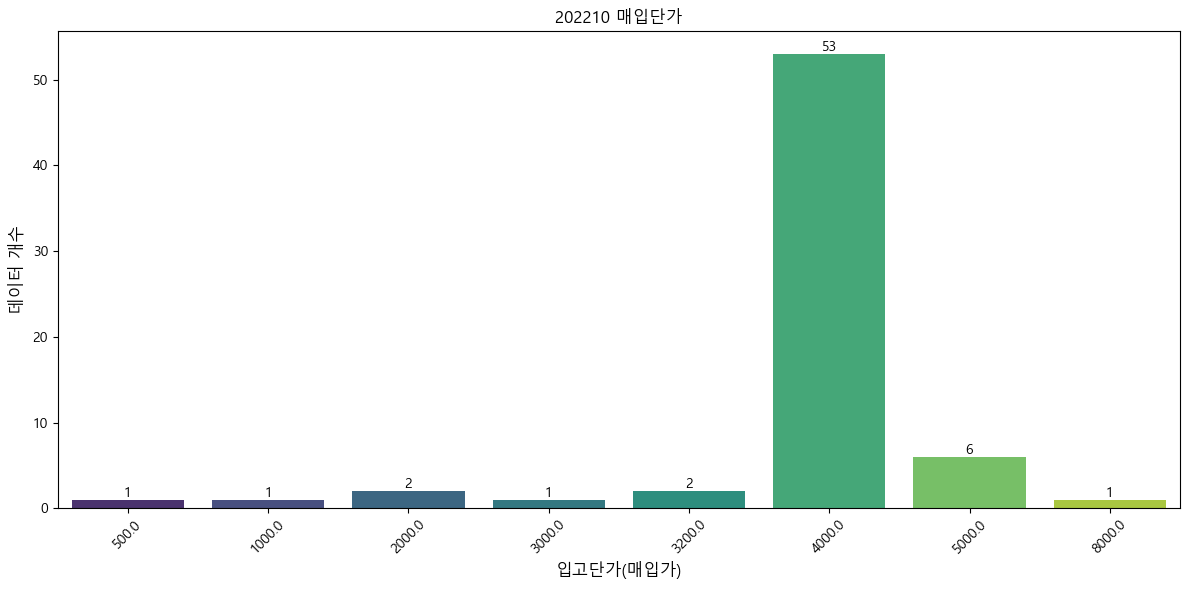

📁 분석결과가 '120G SSD의 202210 매입단가 분석.xlsx'파일에 저장되었습니다.
 
1: 전체 매입단가 분석
2: 날짜 선택으로 매입단가 분석
3: 새로운 키워드 입력
*: 프로그램 종료
 
날짜 입력 예시: 2023년도 데이터 분석➡️2023
날짜 입력 예시: 2023년도 3월 데이터 분석➡️202303
날짜 입력 예시: 2022/03 ~ 2022/06 데이터 분석➡️202203-202206


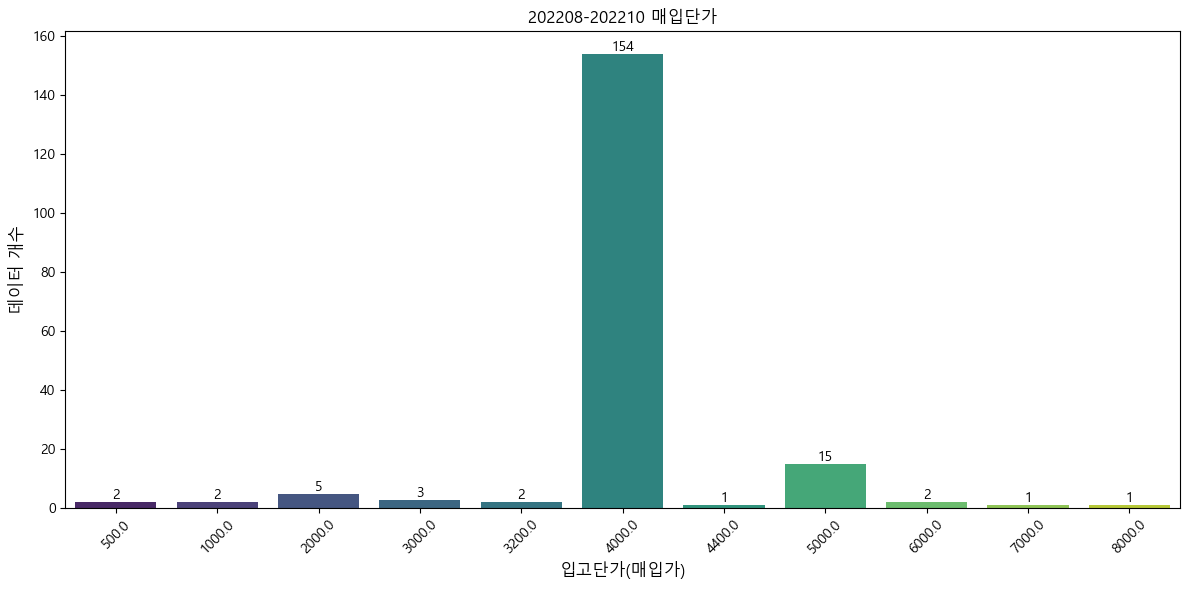

📁 분석결과가 '120G SSD의 202208-202210 매입단가 분석.xlsx'파일에 저장되었습니다.
 
1: 전체 매입단가 분석
2: 날짜 선택으로 매입단가 분석
3: 새로운 키워드 입력
*: 프로그램 종료
 
💡 프로그램을 계속 실행합니다.
 
1: 전체 매입단가 분석
2: 날짜 선택으로 매입단가 분석
3: 새로운 키워드 입력
*: 프로그램 종료
 
💡 프로그램을 계속 실행합니다.
 
1: 전체 매입단가 분석
2: 날짜 선택으로 매입단가 분석
3: 새로운 키워드 입력
*: 프로그램 종료
 
⛔ 프로그램을 종료합니다.


In [26]:
def main_flow(): # 메인 제어 함수
    while True:
        result = get_id()
        if result is None:  # 종료 플래그 처리
            break

        id_name, code_df = result  # 유효한 값만 언패킹

        while True:  
            result = root_analysis(id_name, code_df)
            if result == "exit":  # 분석 종료
                return
            elif result == "restart":
                break  # `get_id`로 돌아가기
            else: 
                id_name, code_df = result
                
main_flow()